# Homework #7

**See Canvas for this assignment and due date**. Complete all of the following problems. Ideally, the theoretical problems should be answered in a Markdown cell directly underneath the question. If you don't know LaTex/Markdown, you may submit separate handwritten solutions to the theoretical problems, but please see the [class scanning policy](https://docs.google.com/document/d/17y5ksolrn2rEuXYBv_3HeZhkPbYwt48UojNT1OvcB_w/edit?usp=sharing). Please do not turn in messy work. Computational problems should be completed in this notebook (using the R kernel). Computational questions may require code, plots, analysis, interpretation, etc. Working in small groups is allowed, but it is important that you make an effort to master the material and hand in your own work. 

## Problem #1: Random effects model

Let $Y_{i,j}$ be the $j^{th}$ measurement of jaw bone density for patient $i$. The one-way random effects model is

$$Y_{i,j}\, | \, \alpha_i \sim N(\alpha_i,\sigma^2)$$

where $\alpha_i \sim N(\mu,\tau^2)$.

The random effect $\alpha_i$ is the true mean for patient $i$ and the observations for patient $i$ vary around $\alpha_i$ with variance $\sigma^2$.

In this model, the population of patient-specific means is assumed to follow a normal distribution with mean $\mu$ and variance $\tau^2$. The hyperparameters have uninformative priors. Specifically, the hierarchical structure is given by:

\begin{align*}
Y_{i,j}\, | \, \alpha_i &\sim N(\alpha_i,\sigma^2) \\
\alpha_i &\sim N(\mu,\tau^2) \\
\mu &\sim N(0,100^2) \\
\sigma^2 &\sim \text{InvGamma}(0.1,0.1) \\
\tau^2 &\sim \text{InvGamma}(0.1,0.1)
\end{align*}


The objective is to borrow strength across patients to estimate the mean for each patient, $\alpha_i$, and to estimate the overall population mean $\mu$.

Here's the data (for now, we're ignoring the `age` variable).

In [1]:
p = 4
ni = 20
n = ni*p; 
 age = c(8.0, 8.5, 9.0, 9.5)
 Y  = c(47.8, 48.8, 49.0, 49.7,
          46.4, 47.3, 47.7, 48.4,
          46.3, 46.8, 47.8, 48.5,
          45.1, 45.3, 46.1, 47.2,
          47.6, 48.5, 48.9, 49.3,
          52.5, 53.2, 53.3, 53.7,
          51.2, 53.0, 54.3, 54.5,
          49.8, 50.0, 50.3, 52.7,
          48.1, 50.8, 52.3, 54.4,
          45.0, 47.0, 47.3, 48.3,
          51.2, 51.4, 51.6, 51.9,
          48.5, 49.2, 53.0, 55.5,
          52.1, 52.8, 53.7, 55.0,
          48.2, 48.9, 49.3, 49.8,
          49.6, 50.4, 51.2, 51.8,  
          50.7, 51.7, 52.7, 53.3,
          47.2, 47.7, 48.4, 49.5,
          53.3, 54.6, 55.1, 55.3,
          46.2, 47.5, 48.1, 48.4,
          46.3, 47.6, 51.3, 51.8) 


df = data.frame(y = Y,  x = as.factor(rep(1:20,each = 4)), age = rep(age, ni)) #different format (for frequentist estimation)

#summary(df)
Y = matrix(Y,20,4,byrow=TRUE)


First, we look at a frequentist fit of this model. The `lmer()` function (in the `lme4` library) fits the random effects model using restricted maximum likelihood estimation (REML). We won't concern ourselves with the details of REML; instead, we'll use this as a baseline for our Bayesian inference.

`lmer()` functions a lot like `lm()`. The main difference is that random effects are distinguised by vertical bars, `( | )`. For example: `lmer(response ~ (1 | random.effect), data = df)` will fit a one-way random effects model.

**Fit the one-way random effects model for these data, then compute and interpret the interclass correlation coefficient.**

In [2]:
#frequentist version
library(lme4)
#summary(lm(y ~ x, data = df)) #fixed effects
freq_est = lmer(y ~ (1 | x), data = df)
summary(freq_est)
5.735/(5.735 + 2.117)
#5.704 + 2.542 = 8.246 tau^2 + sigma^2

Loading required package: Matrix


Linear mixed model fit by REML ['lmerMod']
Formula: y ~ (1 | x)
   Data: df

REML criterion at convergence: 334.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.19089 -0.59038  0.01597  0.52903  2.80018 

Random effects:
 Groups   Name        Variance Std.Dev.
 x        (Intercept) 5.735    2.395   
 Residual             2.117    1.455   
Number of obs: 80, groups:  x, 20

Fixed effects:
            Estimate Std. Error t value
(Intercept)  50.0750     0.5597   89.47

[1] 0.7303872

Here we see that $\widehat\sigma^2 \approx 2.12$, $\widehat\tau^2 \approx 5.74$, and the **intraclass correlation coefficient (ICC)** is given by $\frac{\widehat\tau^2}{\widehat\tau^2 + \widehat\sigma^2} \approx \frac{5.74}{2.12 + 5.74} \approx 0.73$ The ICC estimates the correlation among observations within the same factor level, i.e., correlations among density measurements on the same child.


The ICC can help with:

1. Determining whether or not random effects are necessary. If the ICC is likely to be zero or close to zero (based on a posterior assessment), then observations within factor levels are no more similar than observations from different factor levels.

2. Estimating the percentage of the overall variation in the response that is explained by the factor levels.  

In our repeated measures bone density study, the ICC can help decide to what extent:
- bone density is the kind of thing that varies across different children, but not within an individual child across time; or
- bone density is relatively fixed across the population of children at a particular time, but for an individual child, it varies more as a function of time (e.g., age).

In this case, we estimated that $\approx 0.73$ of the variation in bone density can be attributed to differences across differen children, and $\approx 0.27$ of the variation in bone density can be attributed to differences within a specific child. More variation across children than within a child across time.

Now, let's conduct the Bayesian analysis. In lecture, we showed that the joint posterior can be written as conditional distributions that are posteriors based on conjugate relationships. 

**Code them here and use them in a Gibbs sampling algorithm.**

In the first cell, initialize any values/vectors. In the second, write your Gibbs algorithm.

In [3]:
n.iters = 10000

alpha = matrix(0,n.iters,ni) #initialize the mcmc matrix for alpha
theta = matrix(0,n.iters,3) #initializing the mcmc matrix for mu, tau2, and sig2

#prior
mu0 = 0; sig20 = 100^2
a = 0.1; b = 0.1

# Initial values
sig2 = 1; mu = mean(Y); tau2 = 1 
ai = rowMeans(Y); 
theta[1,] = c(mu, tau2, sig2)
alpha[1,] = ai


In [4]:
set.seed(4929)
#The Gibbs algorithm
  for(i.gibbs in 2:n.iters){
       ai = rep(NA,ni)
        for (i in 1:ni){
            #alpha_i|alpha_-i,mu,sig2,tau2,Y
            S2 = 1/(1/tau2 + p/sig2)
            M = S2*(mu/tau2 + sum(Y[i,])/sig2) # or rowSums(Y)[i]
            ai[i] = rnorm(1,M,sqrt(S2)); 
            alpha[i.gibbs,] = ai
        }

        #mu | .
        s2 = 1/(1/sig20 + ni/tau2)
        m = s2*(mu0/sig20 + sum(ai)/tau2) #mu0/sig20 = 0
        mu = rnorm(1, m, sqrt(s2))
        theta[i.gibbs,1] = mu

        #tau2 | .
        A = ni/2 + a
        B = sum((ai - mu)^2)/2 + b
        tau2 = 1/rgamma(1,A,B)
        theta[i.gibbs,2] = tau2
      
        #sig2 | .
        A = n/2 + a
        B = sum(sweep(Y, 1, ai, "-")^2)/2 + b
        sig2 = 1/rgamma(1,A,B)
        theta[i.gibbs,3] = sig2
      
      }

**Provide some evidence that your Gibbs samplier was programmed correctly.**

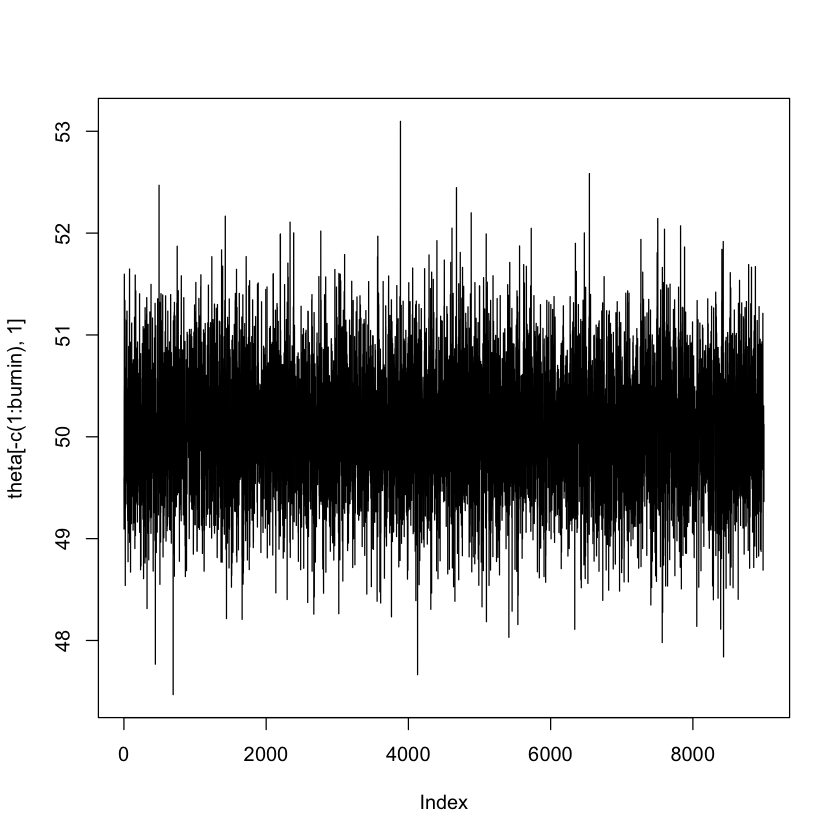

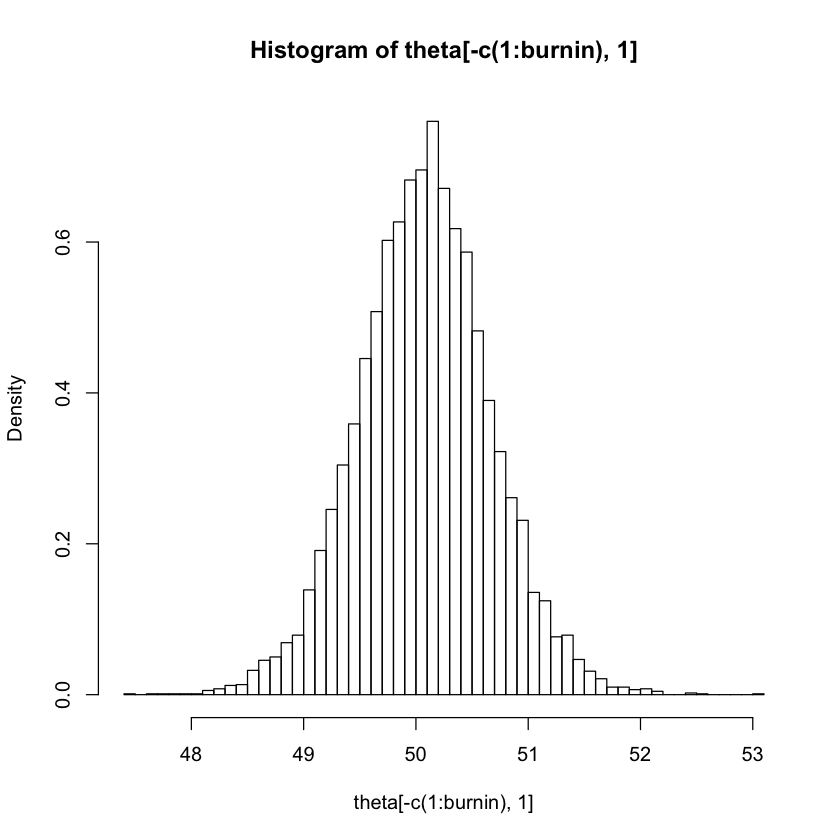

In [5]:
burnin = 1000
plot(theta[-c(1:burnin),1], type = "l")
hist(theta[-c(1:burnin),1], breaks = 70, prob = TRUE)

**Produce estimates of all parameters and hyperparameters and compute the ICC.**

[1] 50.078112  6.372116  2.197422

The MCMC ICC estimate is 0.726 . The frequentist ICC estimate is  0.73

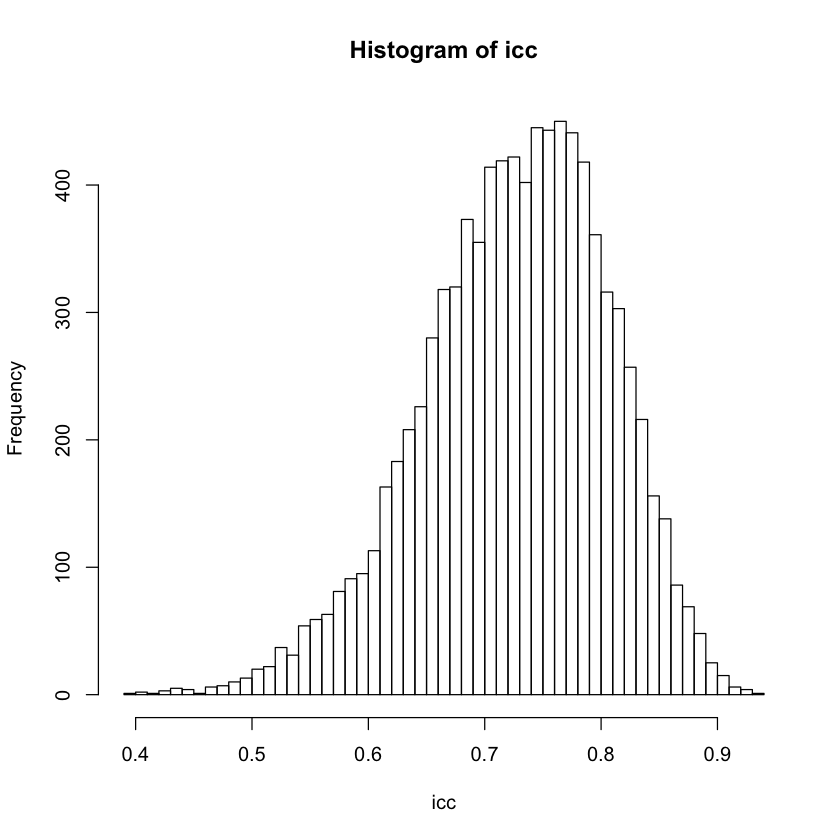

In [6]:
alphahat = colMeans(alpha[-c(1:burnin),]);
thetahat = colMeans(theta[-c(1:burnin),]);

thetahat

icc = theta[-c(1:burnin),2]/(theta[-c(1:burnin),2] + theta[-c(1:burnin),3])
hist(icc, breaks = 50)
sig2hat = mean(theta[-c(1:burnin),2]); 
tau2hat = mean(theta[-c(1:burnin),1]); 

cat("The MCMC ICC estimate is", round(mean(icc),3), ". The frequentist ICC estimate is ", round(5.735/(5.735 + 2.117),3))
#summary(freq_est)

Recall that the ICC is an estimate of the percentage of variability in bone density due to differences across children. So, $\approx 28\%$ of the variability in bone density is due to some other variable that has to do with the individual child (say, their age).

What is the probability that $\tau^2 > 0.1$?

In [7]:
tau2dist = theta[-c(1:burnin),2]
sum(tau2dist > 0.1)/(n.iters - burnin)

[1] 1

### Problem 2: Random slope model

In the previous problem, we did not take into account that age will likely impact changes in bone density. **Use a random slope-and-intercept model on these data. That is, model the relationship:**


$$Y_{i,j} = \alpha_{i,1} + \alpha_{i,2}x_j + \varepsilon_{i,j}$$

$$\boldsymbol\alpha_{i} = (\alpha_{i,1}, \alpha_{i,2}) \overset{iid}{\sim} N(\boldsymbol\beta, \boldsymbol\Omega)  $$

$$\boldsymbol\beta \overset{}{\sim} N(\mathbf 0, \,\,100^2 I_2)$$

$$\Omega \sim \text{invWishart}(2.1, \,\, I_2/2.1)$$

$$\sigma^2 \sim \text{invGamma}(0.1,0.1)$$

**where $x_j$ is the age of the $i^{th}$ child.**

In [8]:
set.seed(819)
library(mvtnorm)
#frequentist version

library(lme4)
lmod = lm(y ~ age, data = df); X = model.matrix(lmod); #X[,2] = scale(X[,2]); 
summary(lmod) #fixed effects
freq_est = lmer(y ~  (age | x), data = df)
summary(freq_est)



Call:
lm(formula = y ~ age, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-4.441 -2.200 -0.325  2.175  4.992 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  33.7475     4.5108   7.482 9.43e-11 ***
age           1.8660     0.5145   3.627  0.00051 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.572 on 78 degrees of freedom
Multiple R-squared:  0.1443,	Adjusted R-squared:  0.1333 
F-statistic: 13.16 on 1 and 78 DF,  p-value: 0.0005096


Linear mixed model fit by REML ['lmerMod']
Formula: y ~ (age | x)
   Data: df

REML criterion at convergence: 259.5

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.60108 -0.34137 -0.01006  0.41101  2.41947 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 x        (Intercept) 337.9673 18.3839       
          age           4.6187  2.1491  -0.99
 Residual               0.1934  0.4398       
Number of obs: 80, groups:  x, 20

Fixed effects:
            Estimate Std. Error t value
(Intercept)  49.5812     0.5554   89.27

In [9]:
#prior parameters
a = b = 0.1 #hyperparameters for sig2
v0 = 2.1; A0 = matrix(c(1/2.1,0,0,1/2.1), ncol = 2); #hyperparameters for Omega
mu0 = c(0,0); Omega0 = 100^2*diag(1,2);  #hyperparameters for beta

In [10]:
#inital values and upfront calculations
n.iters = 4000
beta0 = c(0,0) #initial values for beta chain
alpha0 = c(0,0) #initial values for alpha chain
sig2 = 0.1 #initial values for sig2 chain
intercepts = matrix(0,n.iters,ni) #initialize MCMC matrix for intercepts
slopes = matrix(0,n.iters,ni) #initialize MCMC matrix for slopes
beta_mcmc = matrix(0,n.iters,2) #initialize MCMC matrix for population means
sig2_mcmc = matrix(sig2,n.iters,1) #initialize MCMC vector for sig2

Omega0_inv = solve(Omega0) #initial values for Omega_inv

#upfront data and gram matrices
x = X[1:4,2]
X = X[1:4,]; 
gram = t(X)%*%X; 
y = Y

In [11]:
set.seed(4929)
Omega_inv =  Omega0_inv
beta = beta0
Omega_sum = matrix(0,ncol = 2, nrow = 2)


for(i.gibbs in 2:n.iters){
    alpha_i = matrix(NA,ni,2) 
    s = 0 #part of sig2 calculation
    #alpha_i | .
    for (i in 1:ni){
        S2 = sig2*solve(Omega_inv + gram)
        M = 1/sig2*S2%*%(Omega_inv%*%beta + t(X)%*%y[i,])
        alpha_i[i,] = rmvnorm(1,M,S2)
        intercepts[i.gibbs,i] = as.vector(t(alpha_i[i,1]))
        slopes[i.gibbs,i] = as.vector(t(alpha_i[i,2]))
        #for sig2 update:
        s = s + sum((y[i,] - alpha_i[i,1] - alpha_i[i,2]*x)^2) #used in sig2 update
    }
    
    #beta | .
    S2 = solve(Omega0_inv + ni*Omega_inv)
    M = S2%*%(Omega0_inv%*%mu0 + ni*Omega_inv%*%colMeans(alpha_i))
    beta = t(rmvnorm(1,M,S2))
    beta_mcmc[i.gibbs,] = beta
    
    #sig2 | .
    A = ni*p/2 + a
    for (i in 1:ni){ }
    B =  s/2 + b 
    sig2 = 1/rgamma(1,A,B)
    sig2_mcmc[i.gibbs] = sig2
    
    #Omega | .
    one = ni + v0; 
    A1 = matrix(0,ncol = 2, nrow  = 2); 
    for (i in 1:ni) A1 = A1 + (alpha_i[i,] - beta)%*%t(alpha_i[i,] - beta)
    A1 = solve(A0) + A1
    Omega_inv = matrix(rWishart(1,one,solve(A1)), ncol = 2, nrow = 2)
    Omega_sum = Omega_sum + solve(Omega_inv) #running sum
}

In [12]:
burnin = 500

beta_hat = colMeans(beta_mcmc[-c(1:burnin),]);
cat("The MCMC estimates of the population level parameters are", beta_hat, ".")

slopes_hat = colMeans(slopes[-c(1:burnin),]); 
intercepts_hat = colMeans(intercepts[-c(1:burnin),]); 
df_re = data.frame(intercepts = intercepts_hat, slopes = slopes_hat)
names(df_re) = c("intercepts", "slopes"); df_re

cat("The least squares (fixed effects) estimates are", coef(lmod), ".")
Omega_mean = Omega_sum/n.iters
#Omega_mean

The MCMC estimates of the population level parameters are 33.95048 1.843402 .

intercepts,slopes
33.98017,1.697261
33.92775,1.550741
33.90096,1.541232
33.90811,1.382615
33.95875,1.669693
34.05806,2.173193
33.99614,2.193890
33.97175,1.910150
33.86803,2.009808
33.87661,1.497004


The least squares (fixed effects) estimates are 33.7475 1.866 .

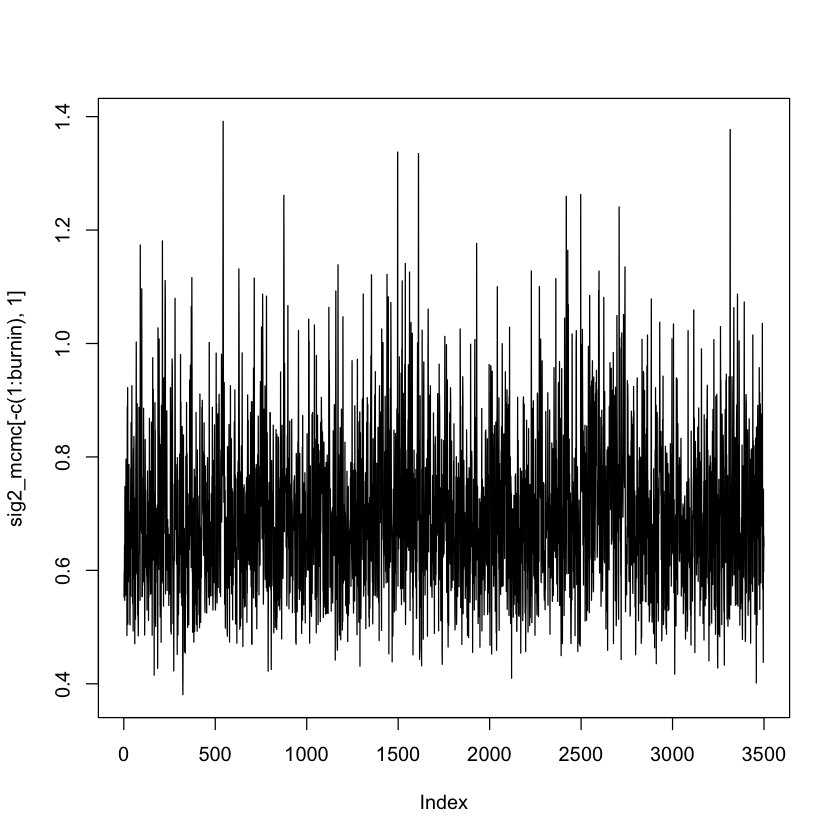

In [13]:
plot(sig2_mcmc[-c(1:burnin),1], type = "l")

### Problem #3

Consider the dataset below, where three operators measured 10 parts three different times.

Specifically, the variables are:
1. `part`: the part number
2. `operator`: the operator number
3. `replicate`: each operator measured each part three times
4. `y`: quality measure   

Source: A. Al-Refaie and N. Bata (2010). "Evalualting Measurement and Process
Capabilities by GR&R with Four Quality Measures," Measurement, Vol. 42,
pp. 842-851.

First, we read in the data. For now, we'll just use the variables `operator` and `y`.

In [14]:
measure = read.table("https://raw.githubusercontent.com/bzaharatos/STAT-5630/main/drill_meas.txt")
names(measure) = c("part", "operator", "replicate", "y")
measure$operator = as.factor(measure$operator)

**Conduct the frequentist one-way random effects analysis of these data, where `y` is the response and `operator` is the factor. This analysis will be used as a baseline for our Bayesian analysis.**

Specifically, in this model, the population of operator-specific measurement means are random effects, assumed to follow a normal distribution with mean $\mu$ and variance $\tau^2$. 


\begin{align*}
Y_{i,j}\, | \, \alpha_i &\sim N(\alpha_i,\sigma^2) \\
\alpha_i &\sim N(\mu,\tau^2) \\
\end{align*}



HINT: You can follow the analysis used in class for the bone density data, i.e., use the `lmer()` function.

In [15]:
#frequentist version
library(lme4)
#summary(lm(y ~ x, data = df)) #fixed effects
freq_est = lmer(y ~ (1 | operator), data = measure)
summary(freq_est)
6.016e-06/(6.016e-06  + 3.677e-03)

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ (1 | operator)
   Data: measure

REML criterion at convergence: -241.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.89287 -0.42620  0.07547  0.73278  1.88945 

Random effects:
 Groups   Name        Variance  Std.Dev.
 operator (Intercept) 6.016e-06 0.002453
 Residual             3.677e-03 0.060640
Number of obs: 90, groups:  operator, 3

Fixed effects:
             Estimate Std. Error t value
(Intercept) 25.615444   0.006547    3913

[1] 0.001633444

**Now, conduct a Bayesian analysis, using the one-way random effects model discussed in class. (Save diagnostics for the next part of the problem.)**

Specifically, in this model, the population of operator-specific measurement means is assumed to follow a normal distribution with mean $\mu$ and variance $\tau^2$. The hyperparameters have uninformative priors. Specifically, the hierarchical structure is given by:


\begin{align*}
Y_{i,j}\, | \, \alpha_i &\sim N(\alpha_i,\sigma^2) \\
\alpha_i &\sim N(\mu,\tau^2) \\
\mu &\sim N(0,100^2) \\
\sigma^2 &\sim \text{InvGamma}(0.1,0.1) \\
\tau^2 &\sim \text{InvGamma}(0.1,0.1)
\end{align*}


In [16]:
p = 3
n.iters = 5000
theta = matrix(0,n.iters,p + 3) #initialize the matrix of chains
colnames(theta) = c("alpha1","alpha2","alpha3","tau2","sig2", "mu")
#prior
mu0 = 0; sig20 = 100^2
a = 0.1; b = 0.1

# Initial values
sig2 = 1; mu = mean(measure$y); tau2 = 1 
ai = with(measure, tapply(y, operator, mean))
ai0 = ai
theta[1,] = c(ai0, tau2, sig2, mu); 
head(theta)

alpha1,alpha2,alpha3,tau2,sig2,mu
25.60433,25.615,25.627,1,1,25.61544
0.00000,0.000,0.000,0,0,0.00000
0.00000,0.000,0.000,0,0,0.00000
0.00000,0.000,0.000,0,0,0.00000
0.00000,0.000,0.000,0,0,0.00000
0.00000,0.000,0.000,0,0,0.00000


In [17]:
set.seed(492)
#The Gibbs algorithm
x = measure$operator; Y = measure$y; n = length(Y); p = with(measure, tapply(y, operator, length))[1]
ni = 3
for(i.gibbs in 2:n.iters){
       ai = rep(NA,ni)
        for (i in 1:ni){
            #alpha_j|alpha_-j,mu,sig2,Y
            S2 = 1/(1/tau2 + p/sig2)
            M = S2*(mu/tau2 + sum(Y[x == i])/sig2)
            ai[i] = rnorm(1,M,sqrt(S2))
            theta[i.gibbs,i] = ai[i]
        }
        #mu | .
        s2 = 1/(1/sig20 + ni/tau2)
        m = (s2*sum(ai))/tau2
        mu = rnorm(1, m, sqrt(s2))
        theta[i.gibbs,6] = mu
      
        #sig2 | .
        A = n/2 + a
        s = 0
        for (i in 1:ni){ s = s + sum((Y[x == i] - ai[i])^2)}
        B =  s/2 + b #sum(sweep(Y, 2, aj, "-")^2)/2 + b #FIX 
        sig2 = 1/rgamma(1,A,B)
        theta[i.gibbs,5] = sig2
      
        #tau2 | .
        A = ni/2 + a 
        B = sum((ai - mu)^2)/2 + b
        tau2 = 1/rgamma(1,A,B)
        theta[i.gibbs,4] = tau2
    
      }



**Produce some diagnostic metrics/plots as evidence of MCMC convergence. Comment on the convergence.**

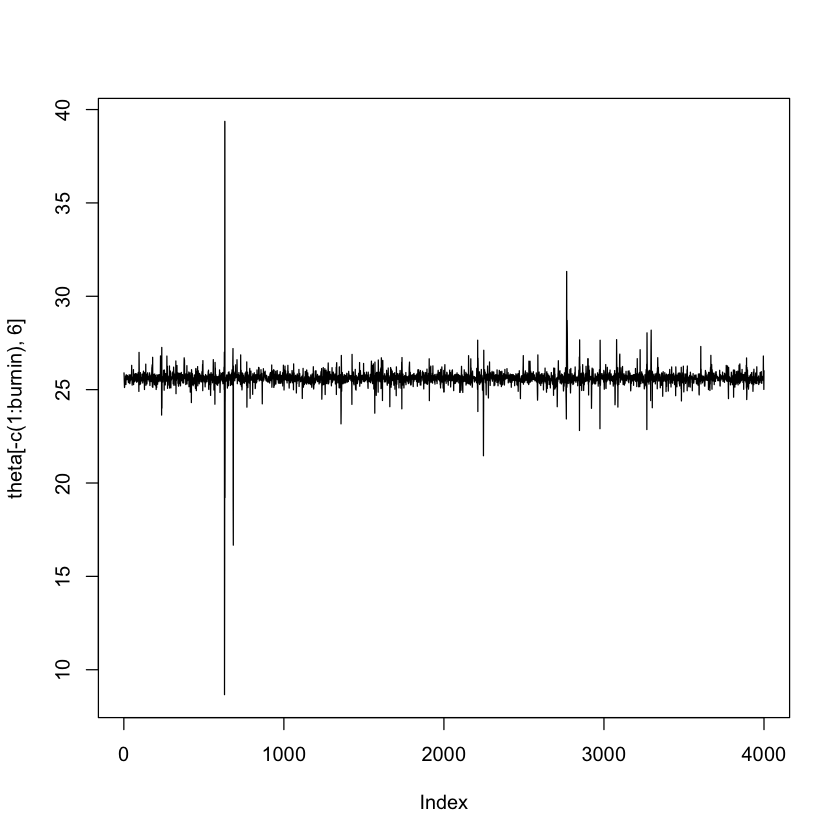

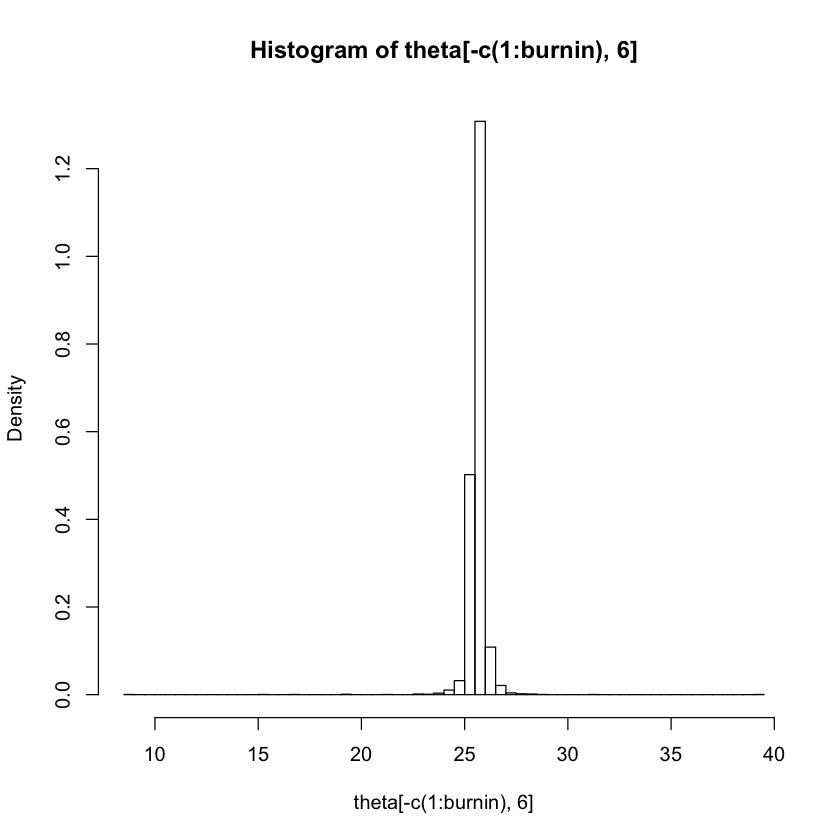

In [18]:
burnin = 1000
plot(theta[-c(1:burnin),6], type = "l")
hist(theta[-c(1:burnin),6], breaks = 70, prob = TRUE)

**Construct a table showing the MCMC means of $\alpha_i$, $\tau^2$, $\sigma^2$, and $\mu$, alongside the frequentist estimates.**

In [22]:
thetahat = colMeans(theta[-c(1:burnin),]);
s = c(with(measure, tapply(y, operator, mean)), 6.016e-06, 3.677e-03, mean(Y)) #rough estimates of means based on the sample data
d = data.frame(thetahat = thetahat, s = s); names(d) = c("MCMC means", "sample means"); round(d,4)

,MCMC means,sample means
alpha1,25.6041,25.6043
alpha2,25.6147,25.6150
alpha3,25.6268,25.6270
tau2,0.7447,0.0000
sig2,0.0061,0.0037
mu,25.6099,25.6154


**Calculate and interpret the intraclass correlation coefficient (ICC).**

In [20]:
sig2hat = mean(theta[-c(1:burnin),6]); 
tau2hat = mean(theta[-c(1:burnin),5]); 

cat("The MCMC ICC estimate is", round(tau2hat/(tau2hat + sig2hat), 4), ". The frequentist ICC estimate is ", 6.016e-06/(6.016e-06  + 3.677e-03))
#summary(freq_est)

The MCMC ICC estimate is 2e-04 . The frequentist ICC estimate is  0.001633444